# Libraries

In [27]:
#Import des libraires 

#Librairies usuelles
import os
import numpy as np
import pandas as pd
from datetime import datetime

#Plots
import plotly.express as px
import matplotlib.pyplot as plt

# Nuage de mot 
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

# Tokenisation, lemmatiser, stop words
import re
from nltk.tokenize  import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import spacy
nlp = spacy.load('en_core_web_sm')

# Distance entre les données de test et les données 
import gensim
from gensim.models import Word2Vec
import sklearn
from  sklearn.manifold import TSNE
import tqdm 


# Data Access
Nous accèdons aux données qui se composent de Fake (fausses) et True (vraies). Nous allons les séparées en fake et true dataset.

In [28]:
fake_df=pd.read_csv("data/Fake.csv")
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [29]:
true_df=pd.read_csv("data/True.csv")
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# Data cleaning
Dans ce dataframe nous analysons si les données sont propres (si elles contiennet des Nan Values, si le type des variables est approprié est approprié. Dans un premier temps nous allons créer un dataframe globale qui contient l'intégralité des données et on va créer une colonne "IsFake" qui contient "True" ou "False" pour classifier les données.


**Des Informations generales**



In [30]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [31]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [32]:
fake_df.shape 

(23481, 4)

In [33]:
true_df.shape

(21417, 4)

**On remarque que les données fake ont des données manquantes**

## Etude de l'équilibrage des données
On va observer si il existe un équilibre dans les données.

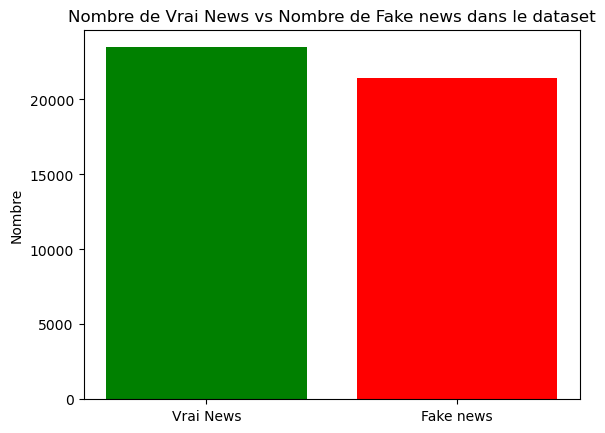

On peut observer un nombre assez équilibrer de notre modèle de 47.7% des données sont fake et 52.3% sont vrai. Ce qui peut nous motiver à enlever des données Fake, afin d'avoir un parfait équilibre entre les deux catégories. Nous allons donc enlever des données du dataset Fake.


In [34]:
#Comparer les tailles de Fake et True permet de savoir si les données sont bien équilibrées (bien distribuées)
fake_value_count=fake_df.shape[0]
true_value_count=true_df.shape[0]
total_news_number= fake_value_count+true_value_count

#donner les valeurs en pourcentage
percentage_true_news=true_value_count/total_news_number
percentage_fake_news=fake_value_count/total_news_number

isFake_counts = {'False': fake_value_count, 'True': true_value_count}  

# Affichage du diagramme pour plus de visibilité 
fig, ax = plt.subplots()
ax.bar(isFake_counts.keys(), isFake_counts.values(), color=['green', 'red'])

ax.set_ylabel('Nombre')
ax.set_title('Nombre de Vrai News vs Nombre de Fake news dans le dataset')
ax.set_xticks(list(isFake_counts.keys()))
ax.set_xticklabels(['Vrai News', 'Fake news'])

plt.show()
print(f"On peut observer un nombre assez équilibrer de notre modèle de {round(percentage_true_news*100,2)}% des données sont fake et {round(percentage_fake_news*100,2)}% sont vrai. Ce qui peut nous motiver à enlever des données Fake, afin d'avoir un parfait équilibre entre les deux catégories. Nous allons donc enlever des données du dataset Fake.")

**Lire Validation_Data**

In [35]:
validation_df = pd.read_csv('data/validation_data.csv')
validation_df.info

<bound method DataFrame.info of       Unnamed: 0                                               text  isFake
0              0  Daniel Greenfield, a Shillman Journalism Fello...   False
1              1  Google Pinterest Digg Linkedin Reddit Stumbleu...   False
2              2  U.S. Secretary of State John F. Kerry said Mon...    True
3              3  — Kaydee King (@KaydeeKing) November 9, 2016 T...   False
4              4  It's primary day in New York and front-runners...    True
...          ...                                                ...     ...
6330        6330  The State Department told the Republican Natio...    True
6331        6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   False
6332        6332   Anti-Trump Protesters Are Tools of the Oligar...   False
6333        6333  ADDIS ABABA, Ethiopia —President Obama convene...    True
6334        6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...    True

[6335 rows x 3 columns]>

In [36]:
validation_df.columns

Index(['Unnamed: 0', 'text', 'isFake'], dtype='object')

## Tokenisation, normalisation, application des stop words, stemming ...

### Voir s'il n'ya pas de données vides 

In [17]:
# Pour title

#Supprimer les cases vides
fake_df = fake_df.dropna(subset=['title'])

#Supprimer les doublons
fake_df = fake_df.drop_duplicates(subset=['title'])

#Supprimer les cases vides
true_df = true_df.dropna(subset=['title'])

#Supprimer les doublons
true_df = true_df.drop_duplicates(subset=['title'])

#Supprimer les cases vides 
#validation_df = validation_df.dropna(subset=['title'])

#Supprimer les doublons
#validation_df = validation_df.drop_duplicates(subset=['title'])

In [20]:
# Pour text 

#Supprimer les cases vides
fake_df = fake_df.dropna(subset=['text'])

#Supprimer les doublons
fake_df = fake_df.drop_duplicates(subset=['text'])

#Supprimer les cases vides
true_df = true_df.dropna(subset=['text'])

#Supprimer les doublons
true_df = true_df.drop_duplicates(subset=['text'])

#Supprimer les cases vides 
validation_df = validation_df.dropna(subset=['text'])

#Supprimer les doublons
validation_df = validation_df.drop_duplicates(subset=['text'])

### Normalisation des données

**Nous definissons la fonction**

In [21]:
#fonction pour nettoyer, tokenizer, lemmatiser  et stemmer
def process_text(text):
    #convertir en minuscules
    text = text.lower()
    #Supprimer les caractères non alphabétiques
    text=re.sub(r'[^a-zA-Z\s]','',text)
    #Enlever html
    text=re.sub(r'\d+','',text)
    #supprimer la ponctuation
    text=re.sub(r'[^\w\s]', '', text)
    #Tokenisation avec NLTK
    tokens= word_tokenize(text)
    #supprimer les stopwords
    stop_words = set(stopwords.words('english'))
    tokens=[word for word in tokens if word not in stop_words]
    #lemmatisation avec spacy
    doc = nlp(" ".join(tokens))
    lemmatized_tokens=[token.lemma_ for token in doc]
    #stemming 
    stemmer = PorterStemmer()
    stemmer_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    #Rejoindre les tokens en une chaine
    processed_text = ''.join(stemmer_tokens)
    return  processed_text

**Cerner les deux colonnes à normaliser et appliquer la fonction sur toutes les lignes du dataset**

In [24]:
import os

# Créer le répertoire 'data_clean' s'il n'existe pas 
output_directory = 'data_clean'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Colonnes à nettoyer
columns_to_clean = ['title','text']

#fake
# Appliquer la fonction à chaque colonne et ajouter une barre de progression
for column in tqdm(columns_to_clean, desc="Processing fake data"):
    fake_df[column + '_processed']= fake_df[column].apply(process_text)

# Exporter les données nettoyées en CSV sans les indices
fake_df.to_csv("data_clean/fake_clean.csv",index=False)

#true
# Appliquer la fonction à chaque colonne et ajouter une barre de progression
for column in tqdm(columns_to_clean, desc="Processing true data"):
    true_df[column + '_processed']= true_df[column].apply(process_text)

# Exporter les données nettoyées en CSV sans les indices
true_df.to_csv("data_clean/true_clean.csv",index=False)

#valid
# Appliquer la fonction à chaque colonne et ajouter une barre de progression
#for column in tqdm(columns_to_clean, desc="Processing validation data"):
    #validation_df[column + '_processed']= validation_df[column].apply(process_text)

# Exporter les données nettoyées en CSV sans les indices
#validation_df.to_csv("data_clean/valid_clean.csv",index=False)


Processing true data: 100%|██████████| 2/2 [10:13<00:00, 306.81s/it]


**Etudier l'équilibrage au sens des thèmes abordés**

Pour assurer un bon équilibrage il ne faut pas seulement se fier aux nombres mais aussi voir si le dataset Fake traite à peu près des mêmes sujets que le dataset True car dans le cas contraire, l'IA pourrait se baser sur le sens pour décider de la justesse de l'information.

Exemple: Si le dataset fake parle plus de trump et le dataset True parle plus de la crise sanitaire celà pourrait biaiser la justesse de l'IA. 
Dès qu'elle aura une information sur Donald Trum elle aura tendance à Pré-classer l'information en tant que Fake News/même Deep Fake, de la même manière elle aura tendance à classer les informations sur la crise sanitaire comme vraies car c'est le sujet qui se rapproche le plus des données True.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rymkm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


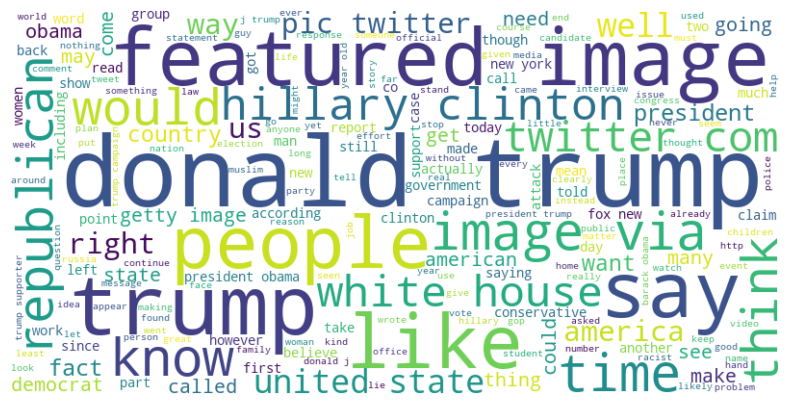

In [25]:
nltk.download('stopwords')

# Charger la liste des stopwords en anglais
stopwords_en = set(stopwords.words('english'))

# Ajouter des mots personnalisés à la liste des stopwords
custom_stopwords = ["said", "ones", "will","one","even","also","u"]
stopwords_en.update(custom_stopwords)

# Concaténer toutes les valeurs de la colonne "text" en excluant les stopwords
text_fake = ' '.join([word.lower() for sentence in fake_df["text"].astype(str) for word in sentence.split() if word.lower() not in stopwords_en])

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_en).generate(text_fake)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rymkm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


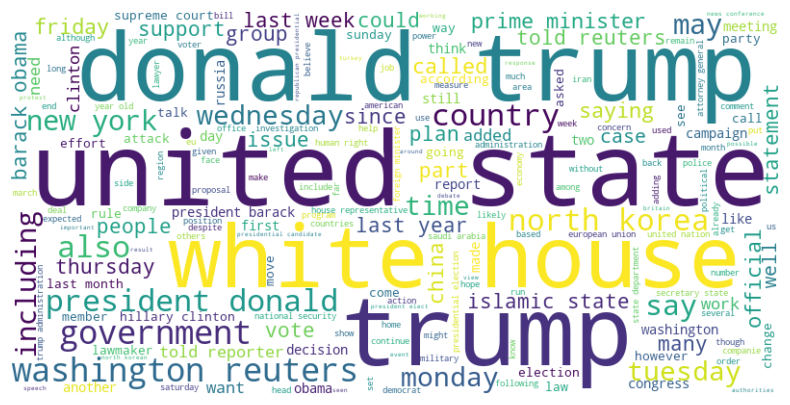

In [26]:
# De même pour les données réelles (True)
nltk.download('stopwords')

# Charger la liste des stopwords en anglais
stopwords_en = set(stopwords.words('english'))

# Ajouter des mots personnalisés à la liste des stopwords
custom_stopwords = ["said", "ones", "will","one","even","u"]
stopwords_en.update(custom_stopwords)

# Concaténer toutes les valeurs de la colonne "text" en excluant les stopwords
text_true = ' '.join([word.lower() for sentence in true_df["text"].astype(str) for word in sentence.split() if word.lower() not in stopwords_en])

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_en).generate(text_true)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# De même pour les données de validation (Validation)
nltk.download('stopwords')

# Charger la liste des stopwords en anglais
stopwords_en = set(stopwords.words('english'))

# Ajouter des mots personnalisés à la liste des stopwords
custom_stopwords = ["said", "ones", "will","one","even","u"]
stopwords_en.update(custom_stopwords)

# Concaténer toutes les valeurs de la colonne "text" en excluant les stopwords
text_true = ' '.join([word.lower() for sentence in true_df["text"].astype(str) for word in sentence.split() if word.lower() not in stopwords_en])

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_en).generate(text_true)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

On remarque que dans les deux dataset Donald Trump est la star! c'est bon signe pour la distribution des données qui ont l'air d'être homogènes pour les mots secondaires 

In [21]:
# prendre un echantillon 
fake_df= fake_df.sample(n=len(true_df),random_state=42)

In [22]:
# On ajoute à chaque dataframe la colonne "isFake"
fake_df["isFake"]=True
fake_df.head(1)

,title,text,subject,date,isFake
4184,Watch Bill Maher Absolutely WRECK Red State V...,Bill Maher laid into red state voters on Frida...,News,"October 15, 2016",True


In [23]:
true_df["isFake"]=False
true_df.head(1)

,title,text,subject,date,isFake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",False


**Concatener le fake et le True dans un seul dataframe df**

In [24]:
df=pd.concat([fake_df,true_df])
df=df.reset_index().drop(['index'],axis=1) #on reset l'index de notre dataset.

In [26]:
#nous allons maintenant adapter les types de données
# Dans quelle format sont les données ?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42834 entries, 0 to 42833
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    42834 non-null  object
 1   text     42834 non-null  object
 2   subject  42834 non-null  object
 3   date     42834 non-null  object
 4   isFake   42834 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.3+ MB


In [27]:
# changer "date" en datetime
unique_dates = df['date'].unique()

invalid_format_dates = []

for date in unique_dates:
    try:
        # Essayer de convertir chaque date
        pd.to_datetime(date.strip(), format='%B %d, %Y')
    except ValueError:
        # Si une erreur se produit, ajouter la date à la liste des formats invalides
        invalid_format_dates.append(date)

print("Dates invalides:", invalid_format_dates)

Dates invalides: ['Jul 3, 2017', 'Mar 8, 2016', 'Apr 9, 2015', 'Apr 20, 2015', 'Dec 22, 2016', 'Jun 29, 2017', 'Jul 8, 2017', 'Sep 7, 2016', 'Aug 14, 2017', 'Dec 6, 2016', 'Mar 22, 2017', 'Sep 18, 2015', 'Feb 13, 2017', 'Dec 16, 2017', 'Dec 2, 2015', 'Sep 9, 2017', 'Jan 20, 2017', 'Jul 13, 2016', 'Nov 13, 2017', 'Aug 23, 2016', 'Apr 6, 2016', 'Oct 11, 2017', 'Oct 8, 2016', 'Oct 13, 2016', 'Oct 13, 2017', 'Nov 13, 2015', 'Jul 8, 2016', 'Nov 30, 2017', 'Aug 4, 2017', 'Dec 12, 2016', 'Oct 17, 2015', 'Dec 1, 2016', 'Oct 23, 2017', 'Jul 27, 2015', 'Mar 20, 2016', 'Jul 26, 2017', 'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg', 'Nov 9, 2016', 'Jul 22, 2017', 'Nov 17, 2017', 'Jul 7, 2015', 'Jul 18, 2016', 'Apr 1, 2016', 'Oct 14, 2017', 'Feb 7, 2016', 'Jun 3, 2017', 'Sep 23, 2017', 'Nov 11, 2016', 'Mar 10, 2016', 'Nov 29, 2016', 'Oct 28, 2015', 'Aug 7, 2015', 'Jun 8, 2016', 'Sep 23, 2016', 'Dec 2, 2017', 'Dec 20, 2017', 'Feb 29, 2016', 'Nov 23, 2016', 'Mar 16, 2017', 'Apr 

Nous pouvons voir que les données ne sont toutes du meme format, il va falloire changer cela. Nous pouvons identifier 3 formats qui ne respectent pas la forme suivante "Mois :
- 'd-MMM-yy' (comme '19-Feb-18')
- 'MMM d, yyyy' (comme 'Dec 31, 2017').
- "des URL de site" 

Concernant les URL nous allons éliminer ces lignes du dataset. Pour les autres valeurs nous allons concevoir un algorithme pour les transformer dans un dataframe convenable.

In [28]:
# filtrer et supprimer les URL, pour simplifier nous allons dire que si 
#la ligne contient le suit pas les formats 'd-MMM-yy' ou 'MMM d, yyyy'  
df['date']

0        October 15, 2016
1          April 13, 2017
2             Jul 3, 2017
3             Mar 8, 2016
4          April 23, 2017
               ...       
42829    August 22, 2017 
42830    August 22, 2017 
42831    August 22, 2017 
42832    August 22, 2017 
42833    August 22, 2017 
Name: date, Length: 42834, dtype: object

In [29]:
dates_numpy_array=df['date'].to_numpy()
dates_numpy_array

bad_format_indexes=[] # les index qui n'ont pas le bon format.
for i in range(len(dates_numpy_array)):
    tab=dates_numpy_array[i].replace(",","").split() # on enleve la virgule et
    if len(tab)!=3:
        bad_format_indexes.append(i) #si le nombre est différent de 3 alors le format n'est pas celui qu'on veut. 

bad_format_indexes

[69,
 714,
 749,
 826,
 2045,
 2751,
 3160,
 3594,
 3899,
 4368,
 5834,
 6010,
 6313,
 6330,
 6505,
 6781,
 6929,
 8426,
 10636,
 11365,
 11899,
 11908,
 12727,
 14103,
 15170,
 15196,
 16204,
 16826,
 16876,
 17588,
 17613,
 17663,
 18334,
 18916,
 19151,
 19423,
 20089,
 20699,
 21379]

Nous avons donc identifié que certaines données ne sont pas dans le format adéquat, nous avons 2 cas à traité:
- les dates au format D-MM-YY
- les urls et les string
Nous pouvons savoir que si le string dépasse une certainne longieur, alors c'est un url ou un long text et nous éliminons la row. Si par contre C'est une date du format d-MM-YY alors nous pouvons juste dansformer la donnée en format que l'on veut.


In [30]:
index_to_delete=[]
for index in bad_format_indexes:
    try: # si c'est un format D-M-Y alors on le change simplement
        date_str=dates_numpy_array[index]
        date_obj = datetime.strptime(date_str, '%d-%b-%y') # on selectionne l'objet avec le format D-M-Y en format datetime.
        new_format = date_obj.strftime('%B %d, %Y')
        dates_numpy_array[index]=new_format
    except: # c'est un long string que nous devrons éffacer.
        index_to_delete.append(index)
    

nous avons donc modifié les formats des dates de D-M-Y.
dates_numpy_array

In [31]:
#mainteannt nous allons remplacer les lignes qui ont étée modifiées
df['date']=dates_numpy_array


In [32]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.date.isnull().unique()

array([False,  True])

Nous avons prouvé que il existe des nan values, donc nous allons eliminer les lignes.

In [33]:
# Éliminer les lignes où la colonne 'date' a des valeurs NaT
df = df.dropna(subset=['date'])
df.date.isnull().unique()

array([False])

Nous avons donc clean la colonne date. Nous verifions les autres colonnes.

In [34]:
df.columns

Index(['title', 'text', 'subject', 'date', 'isFake'], dtype='object')

In [35]:
df.title.isnull().unique()

array([False])

In [36]:
df.text.isnull().unique()

array([False])

In [37]:
df.subject.isnull().unique()

array([False])

Notre dataset est près à l'emplois.

# Data analysis + Visualisation
Nous avons plusieurs points à analyser avant de créer notre model, voici les questions sur lesquelles nous nous focalisons pour répondre aux questions:
Types de "subject" dans le DataFrame :

**Analyse de les sujets les plus présents**
- Combien de catégories uniques de "subject" existent-elles ?
- Y a-t-il une distribution inégale des sujets entre les news fake et vraies ?

**Sujet avec le plus de fake news ou de vraies news**
- Y a-t-il des sujets spécifiques plus susceptibles d'être associés à des fake news ?

**Analyse de la longueur des textes :**
- Quelle est la distribution de la longueur des textes pour les fake news par rapport aux vraies news ?
- La longueur du texte est-elle un indicateur potentiel de fiabilité ?
Répétition des titres :

**Analyse des dates :**
- Quelles sont les dates minimales et maximales ? Y a-t-il des tendances temporelles dans les fake news ?
- Y a-t-il des périodes spécifiques où les fake news sont plus fréquentes ?

L'analyse va nous permettre des réponse à ces questions.

**Combien de catégories uniques de "subject" existent-elles ?**

In [38]:
print(f"Nous avons {len(df.subject.unique())} sujets différents")

Nous avons 6 sujets différents


**Y a-t-il une distribution inégale des sujets entre les news fake et vraies ?**

On observe déja le nombre de données Fake et true dans son ensemble:

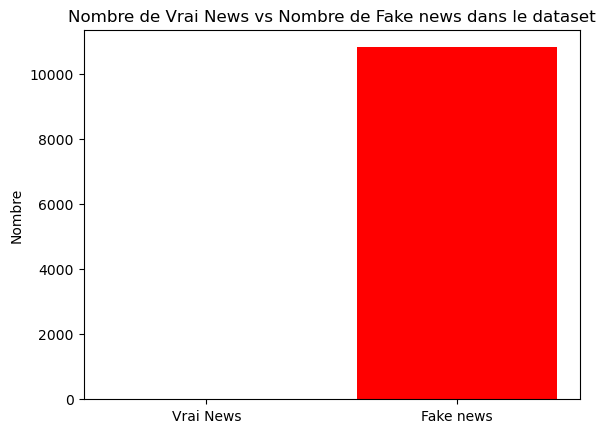

On peut observer un nombre assez équilibrer de notre modèle de 100.0% des données sont fake et 0.0% sont vrai. Ce qui peut nous motiver à enlever des données Fake, afin d'avoir un parfait équilibre entre les deux catégories.  


In [39]:
fake_value_count=df[df["isFake"]==False].shape[0]
true_value_count=df[df["isFake"]==True].shape[0]
total_news_number= fake_value_count+true_value_count

percentage_true_news=true_value_count/total_news_number
percentage_fake_news=fake_value_count/total_news_number

# Sample data
isFake_counts = {'False': fake_value_count, 'True': true_value_count}  # Assuming these are the counts

# Bar chart
fig, ax = plt.subplots()
ax.bar(isFake_counts.keys(), isFake_counts.values(), color=['green', 'red'])

ax.set_ylabel('Nombre')
ax.set_title('Nombre de Vrai News vs Nombre de Fake news dans le dataset')
ax.set_xticks(list(isFake_counts.keys()))
ax.set_xticklabels(['Vrai News', 'Fake news'])

plt.show()
print(f"On peut observer un nombre assez équilibrer de notre modèle de {round(percentage_true_news*100,2)}% des données sont fake et {round(percentage_fake_news*100,2)}% sont vrai. Ce qui peut nous motiver à enlever des données Fake, afin d'avoir un parfait équilibre entre les deux catégories.  ")

In [40]:
df.groupby('subject')['isFake'].value_counts()

subject          isFake
Government News  True       154
Middle-east      True       702
News             True      8241
US_News          True       708
left-news        True       392
politics         True       621
Name: count, dtype: int64

In [41]:
# Grouper par 'subject' et compter les occurrences de True et False dans 'isFake'
count_by_subject = df.groupby('subject')['isFake'].value_counts().unstack().fillna(0)

# Afficher le résultat
print(count_by_subject)

isFake           True
subject              
Government News   154
Middle-east       702
News             8241
US_News           708
left-news         392
politics          621


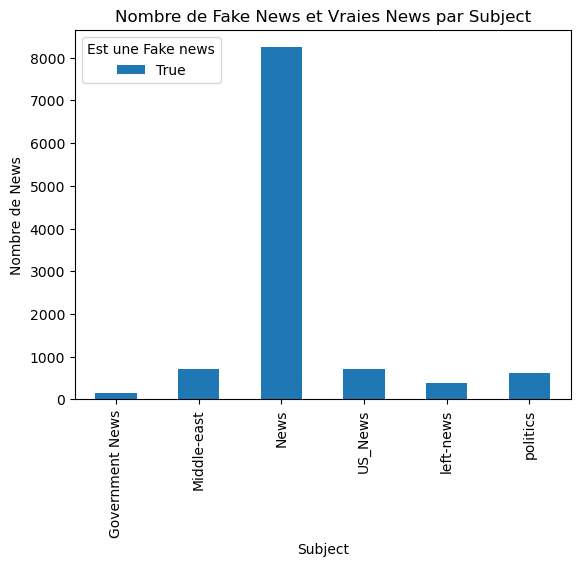

In [42]:
# Créer un graphique à barres empilées
count_by_subject.plot(kind='bar')

# Ajouter des titres et labels
plt.title('Nombre de Fake News et Vraies News par Subject')
plt.xlabel('Subject')
plt.ylabel('Nombre de News')

# Afficher la légende
plt.legend(title="Est une Fake news",loc="upper left")

# Afficher le graphique
plt.show()


La distribution des fake news et des true news est assez innégal si on les reproupe par subject, il es très probable qu'elle ne soit pas un bon estimateur pour détecter les fake news. 
Il serait envisageable:
- Soit utiliser des techniques comme SMOTE pour générer des nouvelles données de la classe minoritaire.
- soit enlever la colonne "subject" du dataset. (car à la fin, ce sont des news, peut importe d'où elles viennent.)

**Sujet avec le plus de fake news ou de vraies news**:
- PoliticsNews
- Worldnews

**Analyse de la longueur des Titres :**

In [43]:
#Quelle est la distribution de la longueur des titres pour les fake news par rapport aux vraies news ?
titles=df[['title','isFake']]
titles.head()

,title,isFake
0,Watch Bill Maher Absolutely WRECK Red State V...,True
1,Democrats Demand Jared Kushner Be Stripped Of...,True
4,Delusional Trump Hilariously Thinks Angela Me...,True
5,SPINELESS: Paul Ryan Actually RAN AWAY From R...,True
6,REPORT: Five-Year-Old Girl Is Detained And Se...,True


In [44]:
title_length=[]
for title in titles['title']:
    title_length.append(len(title))
titles['title length']=title_length

C:\Users\rymkm\AppData\Local\Temp\ipykernel_57260\2468875001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles['title length']=title_length


In [45]:
#on détermine la moyenne de Fake et True
title_length=titles.drop(['title'],axis=1)
title_length

,isFake,title length
0,True,91
1,True,65
4,True,70
5,True,83
6,True,106
...,...,...
21405,True,95
21406,True,130
21407,True,96
21411,True,86


In [46]:
true_title_length=title_length[title_length['isFake']==True]
true_title_length.describe()

,title length
count,10818.000000
mean,83.354594
std,17.291939
min,18.000000
25%,74.000000
50%,84.000000
75%,93.000000
max,208.000000


In [47]:
false_title_length=title_length[title_length['isFake']==False]
false_title_length.describe()

,title length
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [48]:
# Creating plot
fig=px.box(title_length,x='isFake',y='title length',points='all')
 
# show plot
fig.show()

- Les titres des vraies nouvelles ont une longueur moyenne significativement plus longue (94.2 mots) par rapport aux fausses nouvelles (64.7 mots).
- La variabilité (écart-type) dans les longueurs de titres des vraies nouvelles (27.2 mots) est plus grande que celle des fausses nouvelles (9.2 mots), indiquant une plus grande diversité dans la longueur des titres des vraies nouvelles.
- Les fausses nouvelles présentent une longueur de titre plus uniforme
- Les valeurs minimales et maximales montrent que les vraies news ont une plage plus large de longueur de titre.
- La distribution des quartiles montre que les titres de fausses nouvelles sont concentrés dans une plage plus étroite.

On peut conclure que c'est un indicateur potentiel pour la détection de fake news.

**Analyse de la longueur des Titres :**

In [49]:
#Quelle est la distribution de la longueur des titres pour les fake news par rapport aux vraies news ?
textes=df[['text','isFake']]
textes.head()

,text,isFake
0,Bill Maher laid into red state voters on Frida...,True
1,"Donald Trump s son-in-law and senior advisor, ...",True
4,We all remember the absolutely disastrous visi...,True
5,Everyone knows Speaker of the House Paul Ryan ...,True
6,Attorneys are racing to the defense of a child...,True


In [50]:
text_length=[]
for text in textes['text']:
    text_length.append(len(text))
textes['text length']=text_length
textes

C:\Users\rymkm\AppData\Local\Temp\ipykernel_57260\1693554252.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,text,isFake,text length
0,Bill Maher laid into red state voters on Frida...,True,3267
1,"Donald Trump s son-in-law and senior advisor, ...",True,2199
4,We all remember the absolutely disastrous visi...,True,1222
5,Everyone knows Speaker of the House Paul Ryan ...,True,1897
6,Attorneys are racing to the defense of a child...,True,2096
...,...,...,...
21405,Obama is clearly attempting to strip Americans...,True,5125
21406,It s interesting how much vitriol some women h...,True,2895
21407,"Madeleine Albright, who served as Secretary of...",True,2114
21411,While many of us are still trying to understan...,True,2259


In [51]:
true_text_length=textes[textes['isFake']==True]
true_text_length.describe()

,text length
count,10818.000000
mean,2857.915973
std,2644.732912
min,1.000000
25%,1923.000000
50%,2373.000000
75%,3073.750000
max,51794.000000


In [52]:
fake_text_length=textes[textes['isFake']==False]
fake_text_length.describe()

,text length
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [53]:
# Creating plot
fig=px.box(textes,x='isFake',y='text length',points='all')
 
# show plot
fig.show()

- La moyenne des Fake (2383.278517) et des vrais (2548.422777) est sont très proches.
- la variablilité des vrai (2532.933638) news est supeiruer au faux (1684.835730) ceci peut aussi etre expliqué que le nombre de fake news est infeiruer au nombre de vrai news. Mais elle reste élevé dans les deux camps.
- Les quartils, le minimum et maximum, montrent que les vrai news ont une plus petite marge que les fake news. 

Il est important a noter que le nobre de vrai news est beaucoup plus élevé que le nombre de fake news, ceci peut influer  les valeurs. En revanche on peut partir du principe que la longieur du texte peut etre un bon indicateur pour la détection des fake news. (à utiliser avec prudence)

**Analyse des dates :**

In [54]:
df_sorted_by_date=df.sort_values(by='date')
df_sorted_by_date.head()

,title,text,subject,date,isFake
16617,(VIDEO) SICKENING CHALLENGE GOES VIRAL: DISRES...,"A sick new challenge is going viral, urging ...",left-news,2015-05-01,True
8937,(VIDEO) MADNESS IN THE STREETS: OVER 100 COPS ...,Bill O Reilly isn t my favorite and can be bel...,left-news,2015-05-01,True
12230,(VIDEO) ALAN DERSHOWITZ – SAD DAY FOR JUSTICE ...,You re At Forefront Of This Cause And As Youn...,politics,2015-05-01,True
14591,BALTIMORE POLICE UNION WANTS AN INDEPENDANT PR...,The Police Union came out almost immediately a...,Government News,2015-05-01,True
7090,BALTIMORE POLICE UNION WANTS AN INDEPENDANT PR...,The Police Union came out almost immediately a...,left-news,2015-05-01,True


In [55]:
dates=df_sorted_by_date[['date','isFake']]
dates=pd.get_dummies(dates,columns=['isFake'],)
dates.head()

,date,isFake_True
16617,2015-05-01,True
8937,2015-05-01,True
12230,2015-05-01,True
14591,2015-05-01,True
7090,2015-05-01,True


In [56]:
dates=dates.groupby(by='date').sum().rename(columns={'isFake_False':'Fake', 'isFake_True':'Real'})
dates

,Real
date,
2015-05-01,13
2015-05-02,2
2015-05-04,8
2015-05-05,16
2015-05-06,14
...,...
2018-02-15,6
2018-02-16,8
2018-02-17,6


In [57]:
#Quelles sont les dates minimales et maximales ? 
premiere_date=dates.index[0]
derniere_date=dates.index[-1]
premiere_date,derniere_date

(Timestamp('2015-05-01 00:00:00'), Timestamp('2018-02-19 00:00:00'))

On observe que le dataframe contient des données de **3 ans**, nous pouvons étudier si il existe des tendances temporelles dans les fake news.

In [59]:
# Tracer les graphiques
plt.figure(figsize=(12, 6))
plt.plot(dates.index, dates['Fake'], label='Fake News')
plt.plot(dates.index, dates['Real'], label='Real News')
plt.title('Presence des Fake et Vrai news dans le temps')
plt.xlabel('temps')
plt.ylabel('Nombre de news')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'Fake'

<Figure size 1200x600 with 0 Axes>

On peut observer que de la date de départ du 2015-03-31 jusqu'a 2016-1-31 les vrai news sont plus présent, et les fake news sont inéxistants.
À partir de 2016, les fake news ont augmenté de manière conséquente, mais les vrai news rèstent dominant et constant, jusqu'a 2018. Les fake news, présente plus d'írrégularité de parution entre 2016 et 2018, la periode des fake news sur les vrai news attaint son sommet entre 2017-09-01 à 2018-01-01.

Si on devrais entrainer notre model, il serait potentiellemenet important de ne pas inclure la date, car il se peut que le model prédise la validité d'une news en fonction de sa periode de parution. (à confirmer)

In [60]:
#we get now a dataset only with the text, the title and the values to predict. 
data=df[['title','text','isFake']].sample(frac=1).reset_index(drop=True) #on mélange le dataset puis on le reset les index.
data.to_csv('title_text.csv')

# Lemmatization of text and title
We will employ a method called lemmatization, which processes words to return them to their original or root form.

For example, 'runs' and 'ran' would both be lemmatized to 'run.'

This simplifies the learning process for our machine learning model by reducing the complexity of language and standardizing word variations.

In [61]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

# single word lemmatization examples
list1 = ['kites', 'babies', 'dogs', 'flying', 'smiling', 
		'driving', 'died', 'tried', 'feet']
for words in list1:
	print(words + " ---> " + wnl.lemmatize(words))

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\rymkm/nltk_data'
    - 'c:\\Users\\rymkm\\anaconda3\\nltk_data'
    - 'c:\\Users\\rymkm\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\rymkm\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\rymkm\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [52]:
wnl.lemmatize('Speaks')

'Speaks'

In [5]:
string = 'the cat is sitting with the bats on the striped mat under many flying geese'
 
    
# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()
# Converting String into tokens
list2 = nltk.word_tokenize(string)
print(list2)
#> ['the', 'cat', 'is', 'sitting', 'with', 'the', 'bats', 'on',
#   'the', 'striped', 'mat', 'under', 'many', 'flying', 'geese']
 
lemmatized_string = ' '.join([wnl.lemmatize(words) for words in list2])
 
print(lemmatized_string)

['the', 'cat', 'is', 'sitting', 'with', 'the', 'bats', 'on', 'the', 'striped', 'mat', 'under', 'many', 'flying', 'geese']
the cat is sitting with the bat on the striped mat under many flying goose


**Ckean data de test (normalisation**)